In [1]:
import numpy as np
import pandas as pd

In [2]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re

In [3]:
#load one set of data for testing
df = pd.read_table("C:\\Users\\crowe2c\\OneDrive - Wellington City Council\\Documents\\dataintell\\dev_code\\wccsurveytopics\\src\\data\\urban.txt", header=None)
data = open(r"C:\\Users\\crowe2c\\OneDrive - Wellington City Council\\Documents\\dataintell\\dev_code\\wccsurveytopics\\src\\data\\urban.txt", encoding='utf-8')

In [4]:
#Testing
#set to all lowercase
df[0] = df[0].str.lower()
df.head()

0
0  have partially brick house - no visible damage...
1  i feel disappointed about slow action from lgw...
2  build new instead of upgrading should be encou...
3  post christchurch i did everything that was re...
4  ffs just sort out the cycleway improvements. y...

In [5]:
# Remove the new lines from the data
def data_prep(data):
    lines = data.readlines()
    lines[:] = [line.strip() for line in lines]
    return lines

In [6]:
#Testing
#text = data_prep(data)

In [7]:
#English stop words
stop_words =  stopwords.words('english')
#Remove all the stop words from the text and make all letters lower case.
def text_cleaning(text):
    for w in text:
        text = text.split()
        w = w.lower()
        text = [t for t in text if t not in stop_words]
        text = " ".join(text)
    return(text)

In [8]:
#Testing
#Apply the text cleaning to the df. Then change type to a list for top2vec
data = df[0].apply(text_cleaning)
doc = data.tolist()
#doc

In [9]:
from top2vec import Top2Vec as tv

In [10]:
#Apply top2Vec model to the data
#All the parameters could be changed. 
def topvec(doc, rate, workers, minclusters):
    model = tv(documents=doc, speed= rate, workers=workers, ngram_vocab=True, hdbscan_args = {'min_cluster_size': minclusters} )
    num_tops = model.get_num_topics()
    print("number of topics = ",num_tops)
    return model

In [11]:
model = topvec(doc, "learn", 2, 7)

2022-10-31 15:05:57,070 - top2vec - INFO - Pre-processing documents for training
2022-10-31 15:05:57,089 - top2vec - INFO - Creating joint document/word embedding
2022-10-31 15:05:57,506 - top2vec - INFO - Creating lower dimension embedding of documents
2022-10-31 15:06:03,134 - top2vec - INFO - Finding dense areas of documents
2022-10-31 15:06:03,142 - top2vec - INFO - Finding topics


number of topics =  4


In [12]:
def word_clouds(model, topicnum):
    model.generate_topic_wordcloud(topicnum)

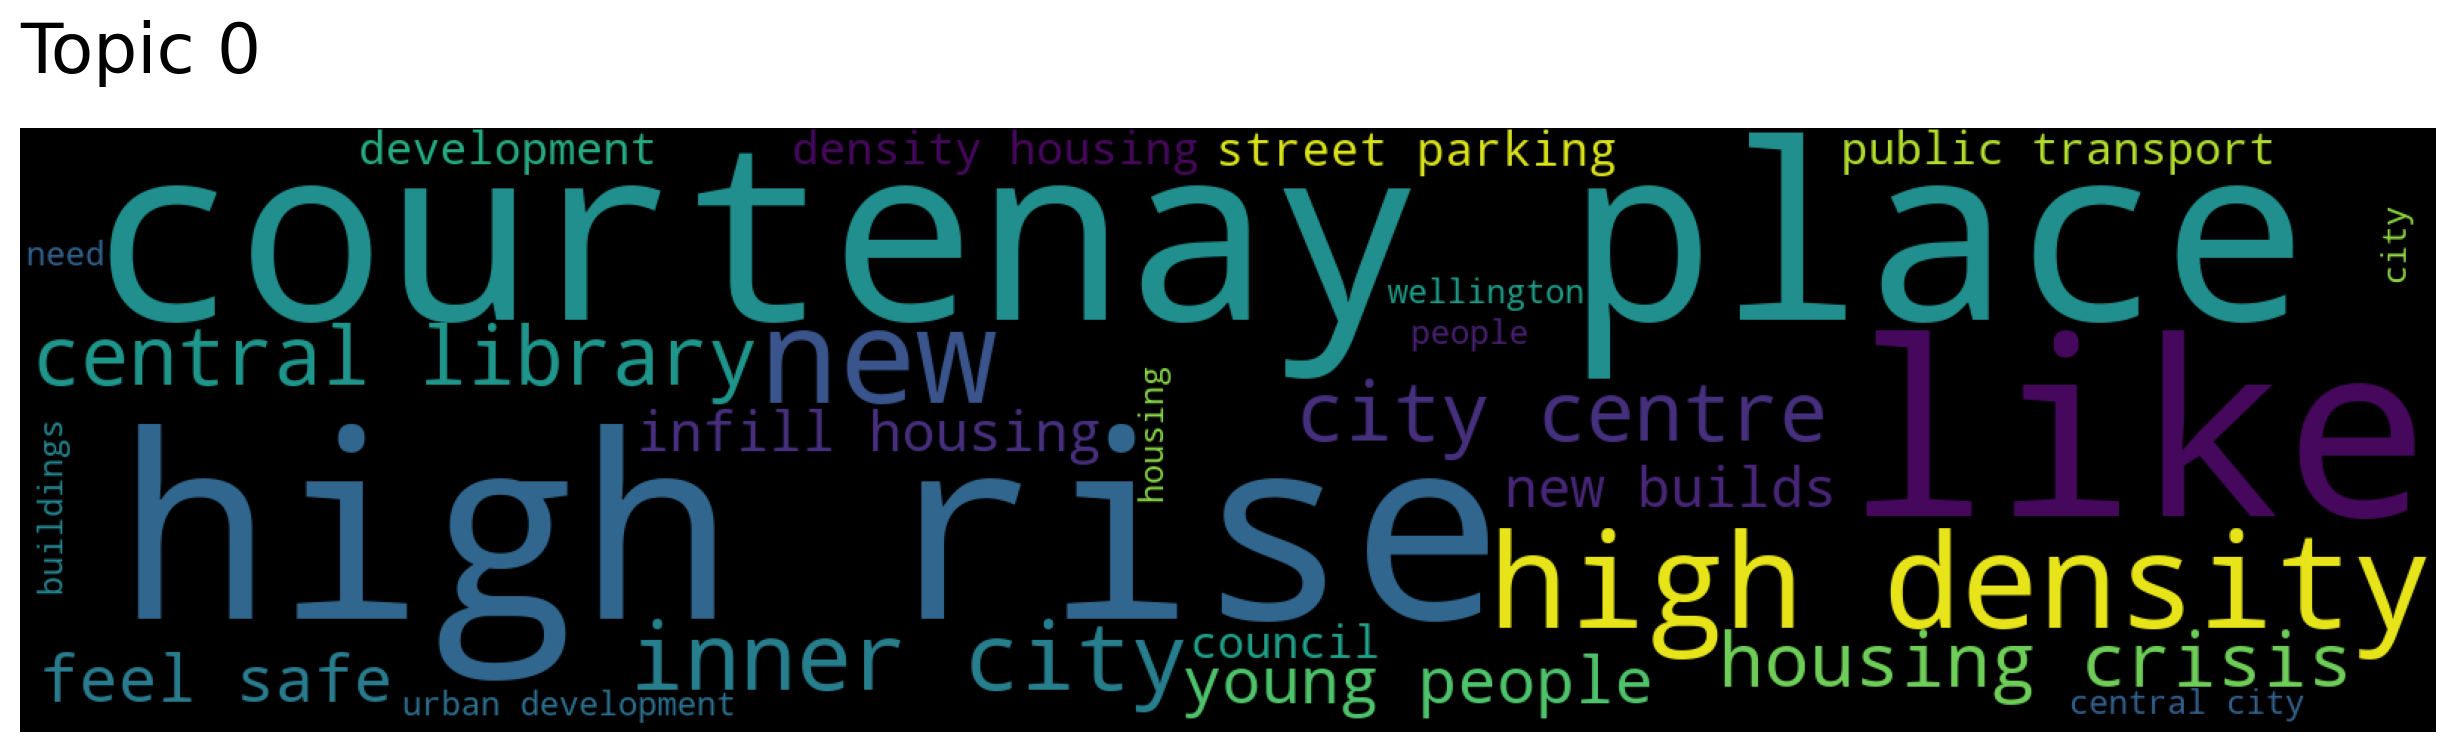

In [13]:
#Print out model word cloud, can chose the topic number.
word_clouds(model, 0)

In [14]:
#Defines each topic
def topic_mapping(model):
    num_tops = model.get_num_topics()
    topic_mapping = model.hierarchical_topic_reduction(num_topics=1)
    topic_sizes, topic_nums = model.get_topic_sizes()
    # get topics
    topic_words, word_scores, topic_nums = model.get_topics(num_tops-1)

    #Create dataframe will all topic words, columns are the topic number
    topic_maps = pd.DataFrame(topic_words).T
    topic_maps.columns = topic_nums
    #print(topic_words)
    return topic_maps

In [15]:
topic_mapping(model)

0                  1                  2
0           high rise  urban development               like
1     courtenay place         wellington     street parking
2                like               need    density housing
3        high density   public transport               need
4                 new            housing     infill housing
5          inner city         inner city        city centre
6     central library     street parking    courtenay place
7         city centre        city centre          high rise
8      housing crisis     housing crisis       young people
9        young people    central library   public transport
10          feel safe        development         inner city
11     infill housing       high density       high density
12         new builds          buildings         new builds
13     street parking               like             people
14   public transport             people            housing
15        development                new          buildings
16    density housing     infill housing  urban development
17            council          high rise            council
18  urban development       central city               city
19         wellington       young people        development
20               need          feel safe                new
21             people            council          feel safe
22               city         new builds       central city
23       central city    courtenay place    central library
24          buildings    density housing         wellington
25            housing               city     housing crisis

In [16]:
#Search topics by a keyword
def search_topic(model, keyword):
    # search topics
    num_tops = model.get_num_topics()
    topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=keyword, num_topics=num_tops-1)

In [17]:
#Testing
#search_topic(model, ["housing"])

In [18]:
#Search quotes by a keyword
def search_doc_keywords(model, keywords):
    num_tops = model.get_num_topics()
    documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=keywords, num_docs=3)
    for doc, score, doc_id in zip(documents, document_scores, document_ids):
        print(f"Document: {doc_id}, Score: {score}")
        print("-----------")
        print(doc)
        print("-----------")
        print()
        return (f"Comment: {doc}, comment number: {doc_id}, Score: {score}")
    

In [19]:
#Testing
#Search_doc_keywords(model, ["housing"])

In [20]:
#Search for words that are similar to a keyword. Results show words that appear with the keyword
def search_similar(model, keyword):
    num_tops = model.get_num_topics()
    words, word_scores = model.similar_words(keywords=keyword, keywords_neg=[], num_words=20)
    for word, score in zip(words, word_scores):
        print(f"{word} {score}")

In [21]:
#Testing
#search_similar(model, ["housing"])

In [22]:
def search_doc_topic(model, topicnumber):
    num_tops = model.get_num_topics()
    toptopic = model.search_documents_by_topic(topicnumber, num_docs=1)
    commentind = int(toptopic[2])
    #print(df.iloc(int(toptopic[2])))
    comment = df.iloc[commentind]
    #print(doc[toptopic[2]])
    return comment

In [23]:
#Testing
search_doc_topic(model,0)

0    would like moderation in in-fill housing, heig...
Name: 342, dtype: object

# FAST API SECTION

In [24]:
import json
from fastapi import FastAPI, Request, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
import csv
import codecs
from io import BytesIO

In [25]:
# Define an API object
app = FastAPI(
    title='NLP',
    description='Designed for the Wellington Residence Survey'
)

In [26]:
from pydantic import BaseModel
class Msg(BaseModel):
    msg: str

In [27]:
#Home/default page
@app.get("/")
async def root():
    return {"message": " Welcome to the NLP API home page!"}


In [28]:
#folderpath = "\\Users\\crowe2c\\OneDrive - Wellington City Council\\Documents\\dataintell\\dev_code\\wccsurveytopics\\src\\data\\"

In [29]:
# Uses the systems folder path. 
import os
print(os.getcwd())
folderpath = os.getcwd()

C:\Users\crowe2c\OneDrive - Wellington City Council\Documents\dataintell\dev_code\fastapi\backend\app


In [30]:
#@app.post("/upload")
#def upload(file: UploadFile = File(...)):
#    print(os.getcwd())
#    contents = file.file.read()
#    #buffer = BytesIO(contents)
#    df = pd.read_csv(file)
#    buffer.close()
#    file.file.close()
#    return df.to_dict(orient='records')

In [31]:
#Creates a top2Vec model from the file that is uploaded.
from typing import Union

@app.post("/uploadfile/")
async def create_upload_file(file: Union[UploadFile, None] = None):
    global model
    if not file:
        return {"message": "No upload file sent"}
    else:
        path = []
        path.append(folderpath)
        path.append(file.filename)
        filepath = rf'{folderpath}\{file.filename}'
        
        df = pd.read_table(filepath)
        #text = data_prep(df)
        
        df.iloc[:,0] = df.iloc[:,0].apply(text_cleaning)
        doc = df.iloc[:,0].tolist()
        
        model = topvec(doc, "learn", 2, 7)
        
        return {"model": file.filename}

In [32]:
#Returns a comment from the orgional data that is from each topic.
@app.get("/toptopic_comment")
def top_comments_(yesorno:str):
    try:
        if(yesorno.lower() == "yes"):
            comments = []
            num_tops = model.get_num_topics()
            for i in range(num_tops):
                comments.append(search_doc_topic(model,i))
            comm_arr = np.array(comments)
            comm_df = pd.DataFrame(comm_arr)
            return(comm_df)
        else:
            return("Not printing any comments")
    except:
        print("Error")

In [33]:
#topvec(doc, "learn", 2, 7) #Testing

In [34]:
#Creates a word cloud if they enter yes in the kernal,
@app.get("/word_cloud")
def word_cloud_(yesorno:str):
    try:
        if(yesorno.lower() == "yes"):
            #word_clouds(model, 0)
            return(word_clouds(model, 0))
        else:
            return ("Word cloud not created")
    except: 
        print("Error")

In [35]:
#Topic mapping from words if they enter yes
@app.post("/topicmapping")
def topic_mapping_(yesorno:str):
    try:
        if(yesorno.lower() == "yes"):
            #print(topic_mapping(model))
            return (topic_mapping(model))
        else:
            return ("Topic mapping not created")
    except:
        return("Error")

In [36]:
#Searches the text for a word. 
#     - the word searched must be a value that the model has identified already.
@app.get("/searchcomments")
def search_comments(keyword:str):
    try:
        #print(topic_mapping(model))
        return (search_doc_keywords(model, [keyword]))
    except:
        return ("Error- There can only be one keyword entered that the model has already seen")

In [37]:
from pyngrok import ngrok

ngrok_tunnel = ngrok.connect(8000)

ngrok_tunnel

<NgrokTunnel: "http://c955-223-26-27-204.ngrok.io" -> "http://localhost:8000">

In [ ]:
import nest_asyncio
import uvicorn

nest_asyncio.apply()
uvicorn.run(app, port=8000)

INFO:     Started server process [1532]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:55614 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:55614 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:55614 - "GET /openapi.json HTTP/1.1" 200 OK


2022-10-31 15:06:38,245 - top2vec - INFO - Pre-processing documents for training
2022-10-31 15:06:38,258 - top2vec - INFO - Creating joint document/word embedding
2022-10-31 15:06:38,691 - top2vec - INFO - Creating lower dimension embedding of documents
2022-10-31 15:06:41,227 - top2vec - INFO - Finding dense areas of documents
2022-10-31 15:06:41,236 - top2vec - INFO - Finding topics


number of topics =  3
INFO:     127.0.0.1:55615 - "POST /uploadfile/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:55637 - "GET /toptopic_comment?yesorno=yes HTTP/1.1" 200 OK
